#Installations

In [ ]:
!pip install pytorch-msssim

#Storage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports


In [ ]:
import torch
import torch.nn as nn
import math
from math import log2, log10, sqrt
import cv2
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import torch
from datetime import datetime
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.optim import SGD, AdamW
import json
import torchvision
import torch.nn.functional as F
import torch.nn
from torch.nn import Linear, ReLU, Softmax, Dropout, Sequential, Conv2d, MaxPool2d, Module, \
    BatchNorm2d, BatchNorm1d
from torch import Tensor
import torch.nn as nn
from typing import Type, Any, Callable, Union, List, Optional
import PIL
import sys
import os
import time
import pandas as pd
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms,utils as vutils
from tqdm import tqdm_notebook
from torch.utils.data import random_split
from IPython.display import HTML
from torchsummary import summary
import logging
import threading
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random 

#ssim loss
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM



#Settings and Constants

In [ ]:
# compression_size = 588
compression_size = 1176
# compression_size = 1764
# compression_size = 2352

lr = 0.0000125


# batch_size = 32 # training 
batch_size = 1 #testing


n_epochs = 500

train_size = 42000



#Data

In [ ]:
#Dataloaders

torch.manual_seed(5111785)

train_transform = transforms.Compose([
    transforms.Resize(224),   
    transforms.ToTensor() 
    ])   

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    ])  


traindata = torchvision.datasets.CIFAR10(root='.', train=True,download=True, transform=train_transform)
trainset,valset = random_split(traindata,[42000,8000])   

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,shuffle=True)

testset = torchvision.datasets.CIFAR10(root='.', train=False,download=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)



Extracting ./cifar-10-python.tar.gz to .


#Patch Embedding

In [ ]:

class PatchEmbed(nn.Module):

    """
    split images into patches of n_channels x patch_size x patch_size 
    """
    
    def __init__(self, img_size, patch_size, in_chans=3, feats_dim_size=768):
        super().__init__()
        self.img_size = img_size
        self.n_patches = (img_size // patch_size) ** 2
        self.feats_dim_size = feats_dim_size



    def forward(self, x):
        

        batch_size = x.shape[0]
        x = x.reshape(batch_size,self.n_patches,self.feats_dim_size)

        return x

#Attention Module

In [ ]:
class Attention(nn.Module):
    """
    Applies n_head self attention to the features
    
    """
    def __init__(self, feats_dim_size, n_heads=12, attn_bias=True):
        super().__init__()
        self.n_heads = n_heads
        self.feats_dim_size = feats_dim_size
        self.head_dim_size = feats_dim_size // n_heads
        self.scaler = self.head_dim_size ** -0.5

        self.qkv_fc = nn.Linear(feats_dim_size, feats_dim_size * 3, bias=attn_bias)
        self.proj_fc = nn.Linear(feats_dim_size, feats_dim_size)
        

    def forward(self, x):
  
        n_samples, n_patches, _ = x.shape

        qkv = self.qkv_fc(x) 

        #split into n-heads
        qkv = qkv.reshape(n_samples, n_patches, 3, self.n_heads, self.head_dim_size)  

        # re-arange dims before performing attention computation
        qkv = qkv.permute(2, 0, 3, 1, 4)  

        query, key, value = qkv[0], qkv[1], qkv[2]
        key_transpose = key.transpose(-2, -1) 
         
        attention = self.scaler*(query @ key_transpose)  # scaled attention
        attention_sft_max = attention.softmax(dim=-1) 
  
        value_weighted_attn = attention_sft_max  @ value 
        value_weighted_attn = value_weighted_attn.transpose(1, 2) 
        value_weighted_attn = value_weighted_attn.flatten(2)

        x = self.proj_fc(value_weighted_attn) 

        return x


#MLP

In [ ]:
class MLP(nn.Module):
  
    def __init__(self, n_in_features, n_hidden_features, n_out_features):
        super().__init__()
      
       
        self.layers = nn.Sequential(*[
                  nn.Linear(n_in_features, n_hidden_features),
                  nn.GELU(),
                  nn.Linear(n_hidden_features, n_out_features)
                                      
        ])

    def forward(self, x):
        return self.layers(x)


#Transformer Module

In [ ]:
class TransformerBlock(nn.Module):

    def __init__(self, feats_dim_size, n_heads, mlp_size_ratio=0.5, attn_bias=True):
        super().__init__()
        self.lyr_norm1 = nn.LayerNorm(feats_dim_size, eps=1e-6)
        self.lyr_norm2 = nn.LayerNorm(feats_dim_size, eps=1e-6)
        self.attn_blk = Attention(
                feats_dim_size,
                n_heads=n_heads,
                attn_bias=attn_bias    
        )
        
        self.mlp_blk = MLP(
                n_in_features=feats_dim_size,
                n_hidden_features=int(feats_dim_size*mlp_size_ratio),
                n_out_features=feats_dim_size)

    def forward(self, x):
        x = x + self.attn_blk(self.lyr_norm1(x))
        x = x + self.mlp_blk(self.lyr_norm2(x))

        return x

#Encoder

In [ ]:

class Encoder(nn.Module):

    def __init__(
            self,
            img_size=224,
            patch_size=16,
            in_chans=3,
            compress_dim_size=2000,
            feats_dim_size=768,
            depth=6,
            n_heads=12,
            mlp_hidden_size_ratio=6,
            attn_bias=True,
            
    ):
        super().__init__()

        self.patch_embed = PatchEmbed(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=in_chans,
                feats_dim_size=feats_dim_size,
        )
        self.compression_feats = nn.Parameter(torch.zeros(1, 1, feats_dim_size))
        self.pos_embed = nn.Parameter(
                torch.zeros(1, 1 + self.patch_embed.n_patches, feats_dim_size)
        )
       
        self.transformer_blocks = nn.ModuleList(
            [
                TransformerBlock(
                    feats_dim_size = feats_dim_size,
                    n_heads=n_heads,
                    mlp_size_ratio=mlp_hidden_size_ratio,
                    attn_bias=attn_bias,
              
                )
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(feats_dim_size, eps=1e-6)
        self.fc = nn.Linear(feats_dim_size, compress_dim_size)


    def forward(self, x):
     
        n_samples = x.shape[0]
        x = self.patch_embed(x)

        compression_feats = self.compression_feats.expand(n_samples, -1, -1)  
        x = torch.cat((compression_feats, x), dim=1)  
        x = x + self.pos_embed  

        for block in self.transformer_blocks:
            x = block(x)
        x = self.norm(x)
        compression_feats_out = x[:, 0] 
        x = self.fc(compression_feats_out)

        return x

#Decoder

In [ ]:
class Decoder(nn.Module):
   

    def __init__(
            self,
            image_chnls=3,
            image_size=224,
            compress_dim_size =2000,
    ):
        super().__init__()

        self.image_chnls = image_chnls
        self.image_size = image_size
     
        out_size = self.image_chnls * self.image_size*self.image_size
        self.fc = nn.Linear(compress_dim_size , out_size)
        
  

    def forward(self, x):
    
        x = self.fc(x)

        batch_size = x.shape[0]
        x = torch.reshape(x, (batch_size, self.image_chnls, self.image_size, self.image_size))

        return x

#Model

In [ ]:
class Model(nn.Module):

  def __init__(self,img_chnls=3,image_size =224, compression_size=2000):
    super(Model, self).__init__()

    self.image_size = image_size
    self.compression_size = compression_size
    self.image_chnls = img_chnls

    self.encoder = Encoder(
            img_size=image_size,
            patch_size=16,
            in_chans=3,
            compress_dim_size=compression_size,
            feats_dim_size=768,
            depth= 6,
            n_heads = 12,
            mlp_hidden_size_ratio=6,
            attn_bias=True,
          
    )
    
    self.decoder = Decoder(
            image_chnls = img_chnls,
            image_size = image_size,
            compress_dim_size = compression_size
            )

  def forward(self,x):
    x = self.encoder(x)
    compression = x
    x = self.decoder(x)
    
    return x, compression


  def save_model(self, path):
        torch.save(self.state_dict(), path)
        return path

  @staticmethod
  def load_model(path, compression_size):
      model = Model(compression_size=compression_size)
      model.load_state_dict(torch.load(path))
      return model

  @staticmethod
  def initialize_weights(layer):
      if type(layer) == Linear:
          torch.nn.init.xavier_uniform_(layer.weight.data)
          layer.bias.data.fill_(0.01)
      if type(layer) == Conv2d:
          torch.nn.init.xavier_uniform_(layer.weight.data)


In [ ]:
print("Model Components")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model.load_model("drive/MyDrive/DL Project/Generator_models/gen_model_100_0.017_size_1176",compression_size).float().to(device)
for x in trainloader:
  summary(model, x[0].shape[1:])
  break

Model Components
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        PatchEmbed-1             [-1, 196, 768]               0
         LayerNorm-2             [-1, 197, 768]           1,536
            Linear-3            [-1, 197, 2304]       1,771,776
            Linear-4             [-1, 197, 768]         590,592
         Attention-5             [-1, 197, 768]               0
         LayerNorm-6             [-1, 197, 768]           1,536
            Linear-7            [-1, 197, 3072]       2,362,368
              GELU-8            [-1, 197, 3072]               0
            Linear-9             [-1, 197, 768]       2,360,064
              MLP-10             [-1, 197, 768]               0
 TransformerBlock-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 2304]       1,771,776
           Linear-14  

#Loss Functions

In [ ]:
def reconstruction_MSE(fake, real):
  return torch.mean((real - fake)**2)


def reconstruction_MAE(fake, real):
  return torch.mean(torch.abs(real - fake))


ms_ssim_module = MS_SSIM(data_range=1, size_average=True, channel=3)
# https://github.com/VainF/pytorch-msssim
#https://www.cns.nyu.edu/pub/eero/wang03b.pdf
def reconstruction_MS_SSIM(fake,real):
  return 1 - ms_ssim_module(fake, real)


def reconstruction_MS_SSIM_MAE(fake,real):
  #https://arxiv.org/pdf/1511.08861.pdf

  alpha = 0.84
  ms_ssim_loss = 1 - ms_ssim_module(fake, real)
  mae_loss = torch.mean(torch.abs(real - fake))

  loss = alpha * ms_ssim_loss + (1-alpha)* mae_loss

  return loss



#Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = Model(compression_size = compression_size).float().to(device)
model = Model.load_model(f"drive/MyDrive/DL Project/Generator_models/gen_model_100_0.017_size_1176",compression_size).float().to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                                 factor=0.5, patience=2,
                                                                 threshold=0.0001, threshold_mode='rel', cooldown=0,
                                                                 min_lr=0,
                                                                 eps=1e-08, verbose=True)


prev_epoch_loss = 10
for epoch in range(n_epochs):
    
    model.train()
    epoch_mae_loss = []
    epoch_ssim_loss = []
    for  i, (x_data, y_data) in enumerate(trainloader): # For each batch in the dataloader
        # if i *batch_size > 100: break
        model.zero_grad()
        real_features = x_data.to(device).float()
        fake, _ = model(real_features)
        # print(torch.min(real_features), torch.max(real_features))
        # print(torch.min(fake), torch.max(fake))
        # print("_________________")

        mae_loss = reconstruction_MAE(fake,real_features)
        ssim_loss = reconstruction_MS_SSIM(fake,real_features)
        if prev_epoch_loss > 0.10:
          err =  ssim_loss * mae_loss 
        else:
          err = reconstruction_MS_SSIM_MAE(fake,real_features)
        err.backward()
        optimizer.step()
        epoch_mae_loss.append(mae_loss.item())
        epoch_ssim_loss.append(ssim_loss.item())

        del real_features
        del fake
        del err
        torch.cuda.empty_cache()
   
    # Output training stats
    epoch_mae = np.mean(epoch_mae_loss)
    epoch_ssim = np.mean(epoch_ssim_loss)
    print(f"Epoch {epoch} ---- Train MAE Loss: {epoch_mae} Train SSIM Loss: {epoch_ssim}")
    lr_scheduler.step(np.mean(epoch_mae_loss))
    prev_epoch_loss = epoch_mae

    if epoch % 10 == 0:
      model.save_model(path=f"drive/MyDrive/DL Project/Generator_models/gen_model_{epoch}_{round(epoch_mae, 3)}_size_{compression_size}")
      
      with torch.no_grad():
        model.eval()
        val_mae_loss = []
        val_ssim_loss = []
        for  i, (x_data, y_data) in enumerate(valloader):
          # if i *batch_size > 100: break
          real_features = x_data.to(device).float()
          fake, _ = model(real_features)
          _mae_loss = reconstruction_MAE(fake,real_features)
          val_mae_loss.append(_mae_loss.item())
          _ssim_loss = reconstruction_MS_SSIM(fake,real_features)
          val_ssim_loss.append(_ssim_loss.item())

          if i == 0:
            x = real_features[10].cpu().detach().numpy()
            x = np.transpose(x, [1,2,0])
            y = fake[10].cpu().detach().numpy()
            y = np.transpose(y, [1,2,0])
            fig, axes = plt.subplots(1,2,figsize=(10, 10))
            axes[0].imshow(x)
            axes[1].imshow(y)
            plt.show()

            del x
            del y

          del real_features
          del fake
          
          torch.cuda.empty_cache()

        val_epoch_mae = np.mean(val_mae_loss)
        val_epoch_ssim = np.mean(val_ssim_loss)
        print(f"Epoch {epoch} ---- Val MAE Loss: {val_epoch_mae}, Val SSIM Loss: {val_epoch_ssim}")
        print()

#Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


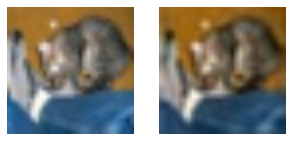

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


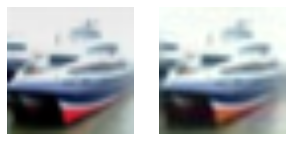

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


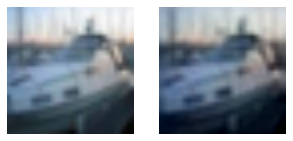

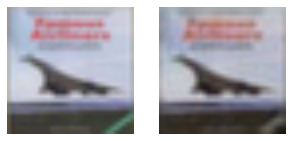

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


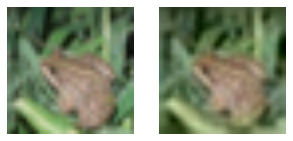

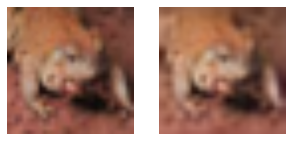

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


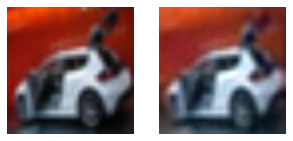

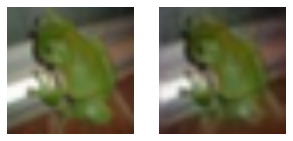

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


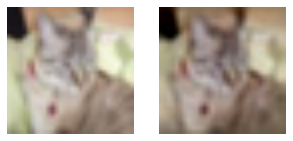

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


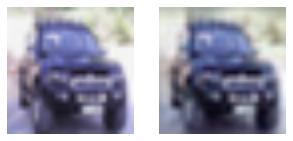

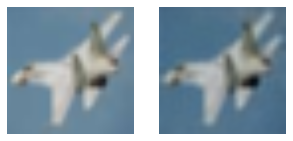

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


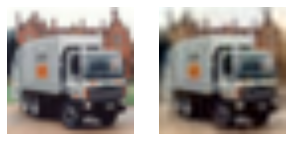

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


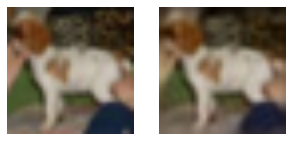

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


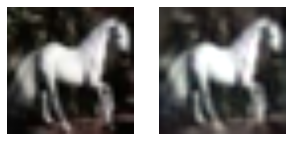

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


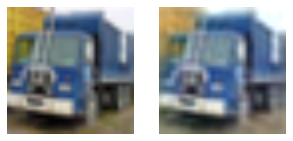

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


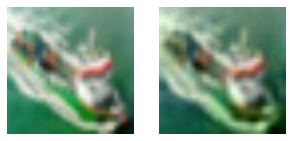

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


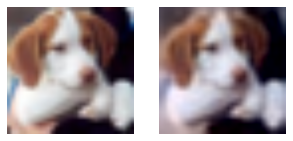

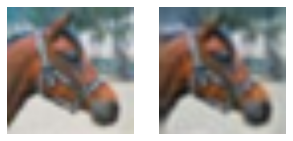

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


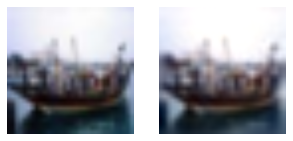

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


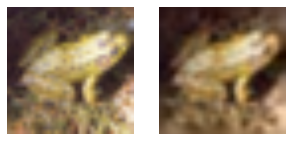

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


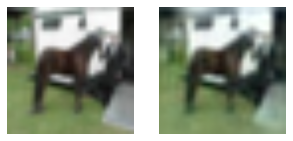

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


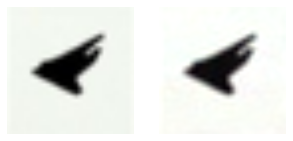

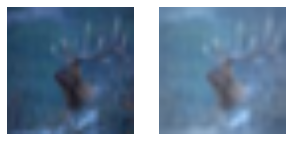

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


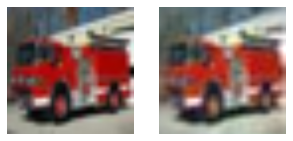

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


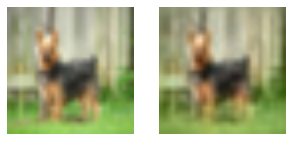

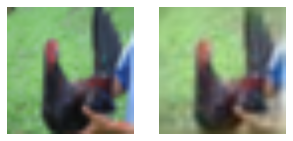

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


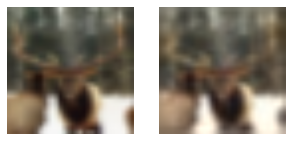

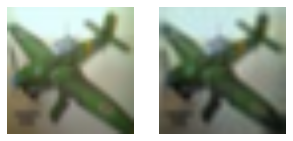

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


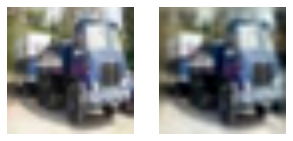

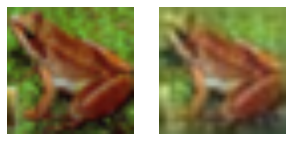

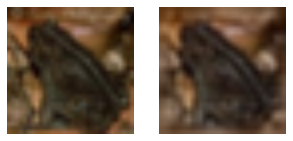

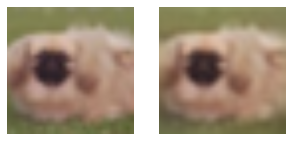

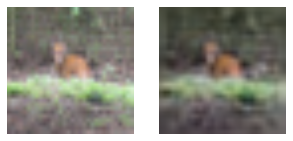

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


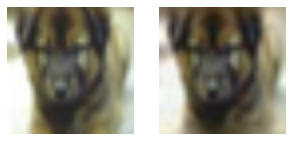

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


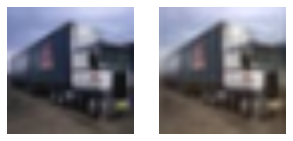

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


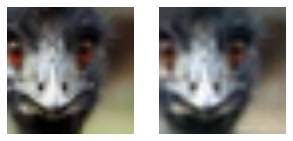

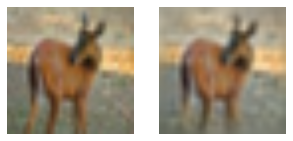

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


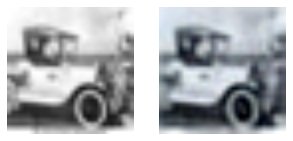

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


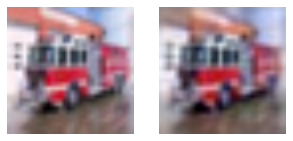

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


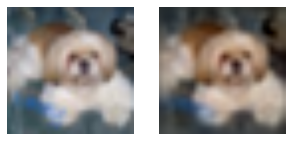

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


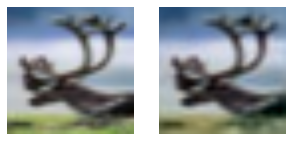

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


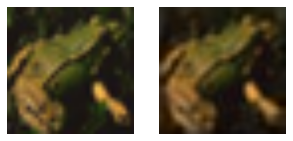

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


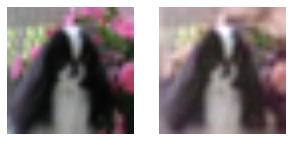

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


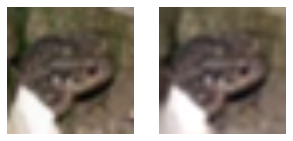

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


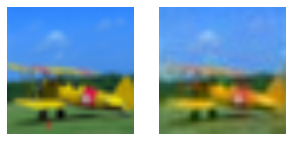

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


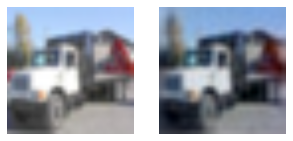

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


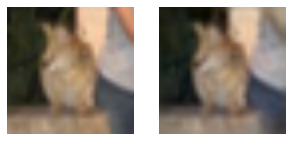

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


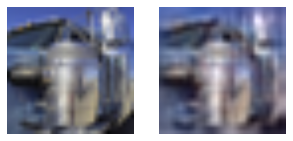

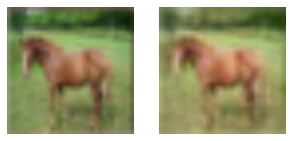

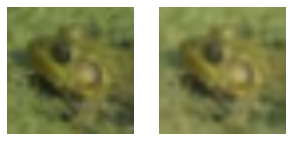

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


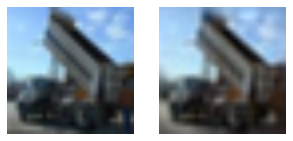

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


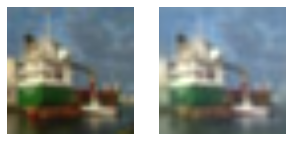

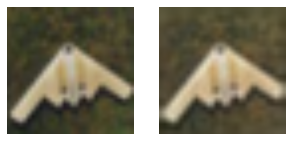

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


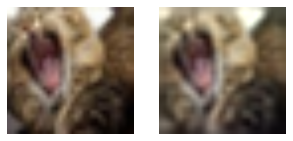

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


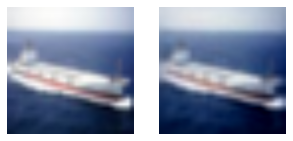

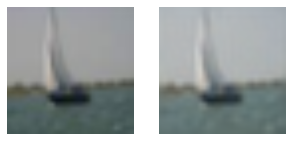

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


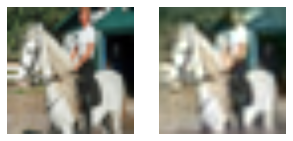

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


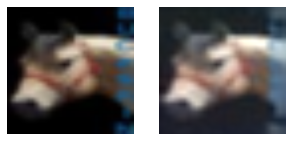

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


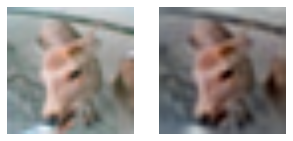

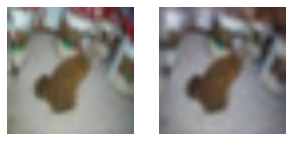

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


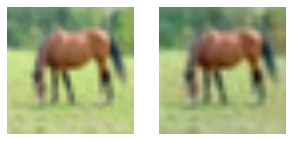

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


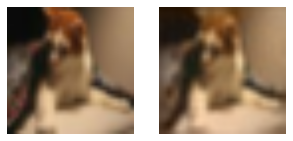

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


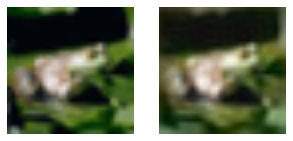

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


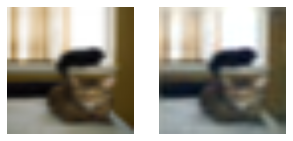

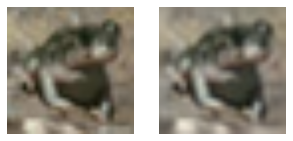

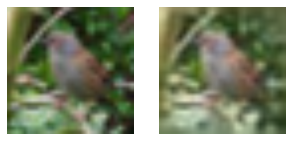

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


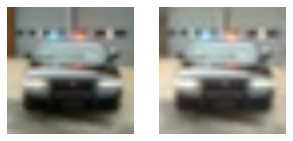

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


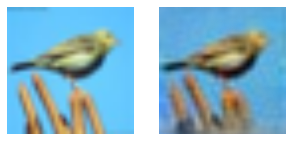

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


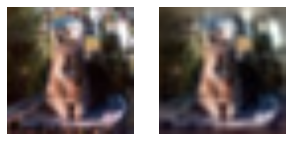

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


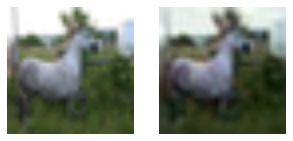

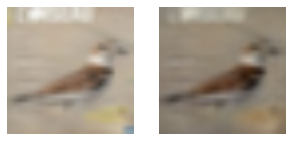

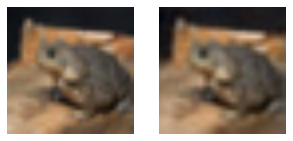

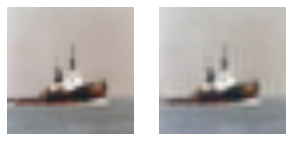

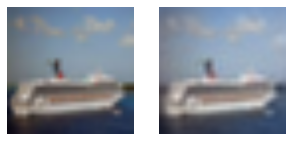

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


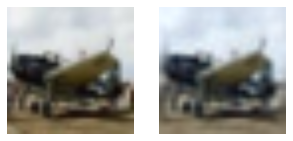

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


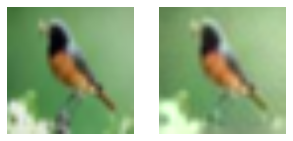

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


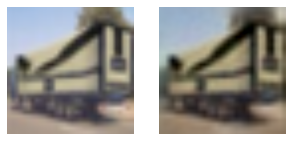

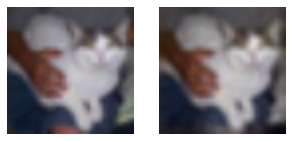

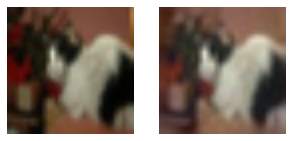

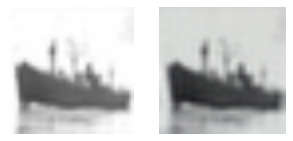

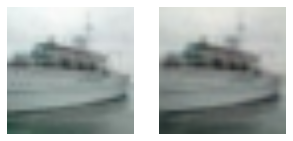

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


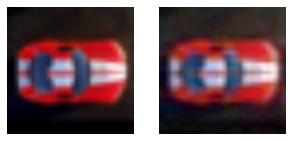

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


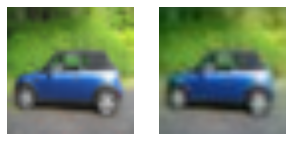

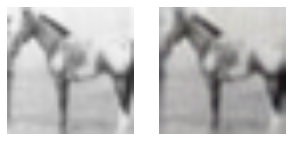

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


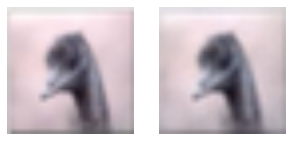

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


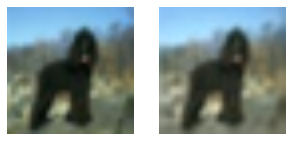

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


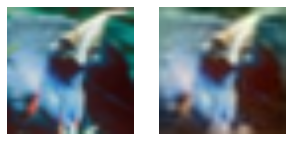

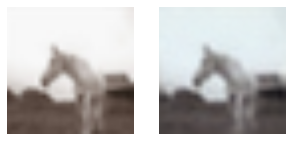

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


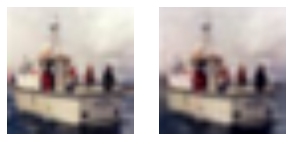

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


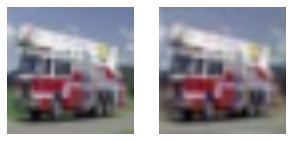

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


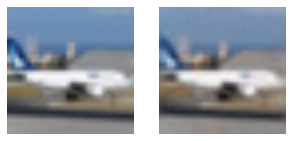

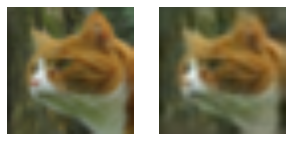

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


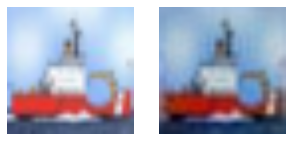

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


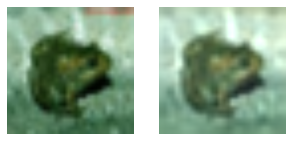

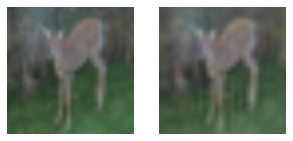

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


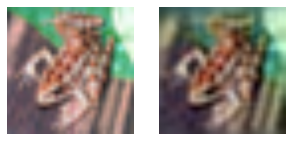

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


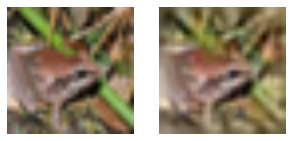

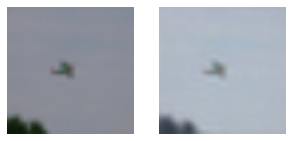

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


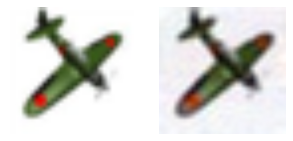

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


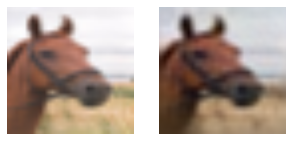




Test MS-SSIM Loss: 0.9769029146432877



In [ ]:
def jpeg_compression()



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = Model(compression_size = compression_size).float().to(device)
model = Model.load_model(f"drive/MyDrive/DL Project/Generator_models/gen_model_10_0.016_size_1176",compression_size).float().to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))


with torch.no_grad():
    model.eval()
    ms_ssim_ = []
    for  i, (x_data, y_data) in enumerate(testloader):
      if i *batch_size >= 100: break

      real_features = x_data.to(device).float()
      fake, _ = model(real_features)

      ms_ssim = 1-reconstruction_MS_SSIM(fake,real_features)
      ms_ssim_.append(ms_ssim.item())

      if i < 100:
        x = real_features[0].cpu().detach().numpy()
        x = np.transpose(x, [1,2,0])
        y = fake[0].cpu().detach().numpy()
        y = np.transpose(y, [1,2,0])
        fig, axes = plt.subplots(1,2,figsize=(5, 5))
        axes[0].imshow(x)
        axes[0].set_axis_off()
        axes[1].imshow(y)
        axes[1].set_axis_off()
        plt.show()

        del x
        del y

      del real_features
      del fake
      
      torch.cuda.empty_cache()

   
    ms_ssim = np.mean(ms_ssim_)
    print('\n\n')
    print(f"Test MS-SSIM Loss: {ms_ssim}")
    print()

#Test Speed

In [ ]:

# encoding speed
compressions = []
encoding_times = []
with torch.no_grad():
    model.eval()

    for  i, (x_data, y_data) in enumerate(testloader):
      if i *batch_size >= 100: break
      real_features = x_data.to(device).float()
      t0 = time.time()
      compression = model.encoder(real_features)
      t1 = time.time()
      encoding_times += [t1-t0]
      compressions  +=[compression]


#decoding speed
decoding_times = []
with torch.no_grad():
    model.eval()
    for  compression in compressions:
      t0 = time.time()
      decompression = model.decoder(compression)
      t1 = time.time()
      decoding_times += [t1-t0]
      

encoding_t = np.mean(encoding_times)  
decoding_t = np.mean(decoding_times)  
print(f"Encoding Time: {encoding_t}, Decoding Time: {decoding_t}")
     





Encoding Time: 0.0026064443588256834, Decoding Time: 3.6094188690185544e-05
